# Estimating Time from Referral to Procurement

**Objective:** Predict the time interval between hospital referral and organ procurement.

**Features:**

- Patient Demographics: `Age`, `Gender`, `Race`
- Medical Details: `Cause_of_Death_UNOS`, `Mechanism_of_Death`, `Circumstances_of_Death`, `ABO_BloodType`, `ABO_Rh`, `HeightIn`, `WeightKg`
- Referral and Authorization Details: `Tissue_Referral`, `Eye_Referral`, `brain_death`, `approached`, `authorized`
- Timing Information: `time_brain_death`, `time_asystole`, `time_referred`, `time_approached`, `time_authorized`, `Referral_Year`, `Referral_DayofWeek`, `Procured_Year`
- Outcome: `outcome_heart`, `outcome_liver`, `outcome_kidney_left`, `outcome_kidney_right`, `outcome_lung_left`, `outcome_lung_right`, `outcome_intestine`, `outcome_pancreas`

**Target:** `time_procured` - `time_referred`

`time_to_procurement`: Calculated as the difference between time_procured and time_referred

**Model Type:** Regression (Linear Regression, Random Forest Regression, Gradient Boosting Regression)

In [1]:
import pandas as pd
# load data bases
df = pd.read_csv('data/referrals.csv')

/tmp/ipykernel_53732/449642640.py:3: DtypeWarning: Columns (7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/referrals.csv')


# Exploratory data Analysis

In [2]:
df.shape

(133101, 38)

We calculate the total number of organ procured by health organization.

In [3]:
df[['time_procured', 'time_referred']].count()

time_procured      9502
time_referred    133101
dtype: int64

In total we got 9502 organs procured. We need to subset our dataset to get only this part.

In [4]:
def filter_data():
    df_sub = df.loc[df['time_procured'].notnull() & df['time_referred'].notnull()].copy()
    return df_sub
df_sub = filter_data()
df_sub.shape

(9502, 38)

## What type is my data?

In [5]:
type(df_sub.loc[df_sub['time_procured'].notna()]['time_procured'].reset_index(drop=True)[1]) # type: ignore

str

In [6]:
type(df_sub.loc[df_sub['time_referred'].notna()]['time_referred'].reset_index(drop=True)[1]) # type: ignore

str

Since both fields are strings, we need to convert into time data type

In [7]:
df_sub['time_referred_time'] = pd.to_datetime(df_sub['time_referred'], format='ISO8601')
df_sub['time_procured_time'] = pd.to_datetime(df_sub['time_procured'], format='ISO8601')

In [8]:
df_sub['time_to_procurement'] = (df_sub['time_procured_time'] - df_sub['time_referred_time']).dt.days

In [9]:
df_sub['time_to_procurement'].mean()

3.589349610608293

## Is ther any outlier?

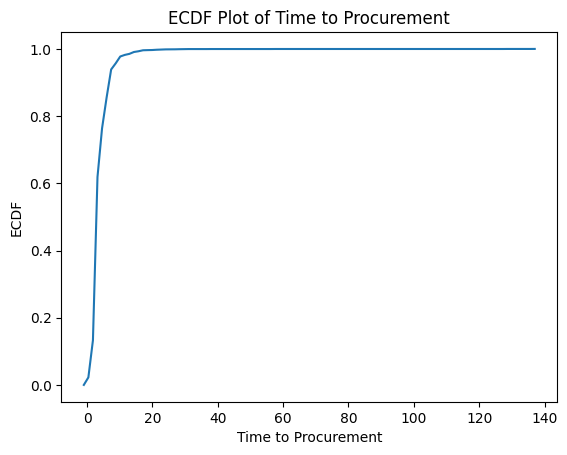

In [10]:
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

# Calculate the ECDF
ecdf = sm.distributions.ECDF(df_sub['time_to_procurement'])

# Generate x values for the ECDF plot
x = np.linspace(min(df_sub['time_to_procurement']), max(df_sub['time_to_procurement']), num=100)

# Calculate the y values for the ECDF plot
y = ecdf(x)

# Plot the ECDF
plt.plot(x, y)
plt.xlabel('Time to Procurement')
plt.ylabel('ECDF')
plt.title('ECDF Plot of Time to Procurement')

plt.show()

In [11]:
y[20]

0.9988423489791622

As we can see, the 99% of data is kept with data from 0 to 20 days. So we keep this data.

In [12]:
df_model = df_sub.loc[
    (df_sub['time_to_procurement'] <= 20) & 
    (df_sub['time_to_procurement'] > 0) # one negative value
    ].copy()

In order to visualize the data, we plot again the distribution:

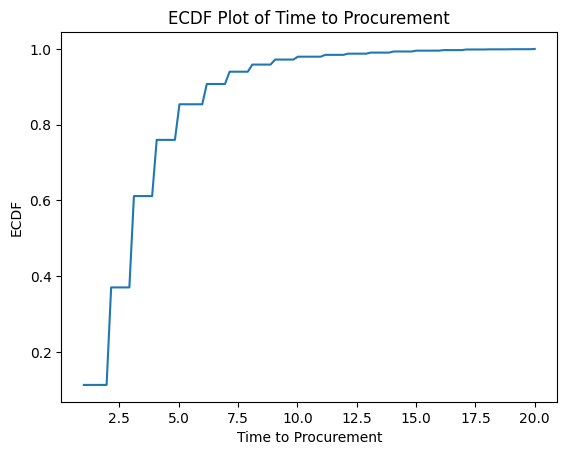

In [13]:
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

# Calculate the ECDF
ecdf = sm.distributions.ECDF(df_model['time_to_procurement'])

# Generate x values for the ECDF plot
x = np.linspace(min(df_model['time_to_procurement']), max(df_model['time_to_procurement']), num=100)

# Calculate the y values for the ECDF plot
y = ecdf(x)

# Plot the ECDF
plt.plot(x, y)
plt.xlabel('Time to Procurement')
plt.ylabel('ECDF')
plt.title('ECDF Plot of Time to Procurement')

plt.show()

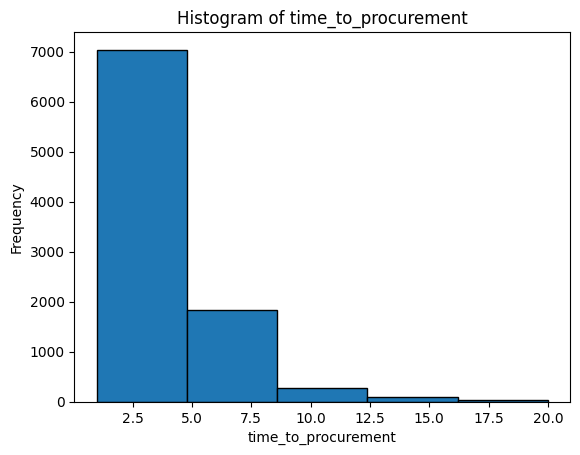

In [14]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(df_model['time_to_procurement'], bins=5, edgecolor='black')

# Add labels and title
plt.xlabel('time_to_procurement')
plt.ylabel('Frequency')
plt.title('Histogram of time_to_procurement')

# Show the plot
plt.show()

We can conclude that data is not normally distributed. 

# Now proceed to develop our model

## model

In [18]:
from pipelines.load_data import load_and_preprocess_data
df_model = load_and_preprocess_data()

/workspaces/health-project-mlops/src/pipelines/load_data.py:13: DtypeWarning: Columns (7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/referrals.csv')


In [43]:
df_model.shape

(9264, 42)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

features = ['Age', 'Gender', 'Race', 'HeightIn', 'WeightKg', 'blood_type', 'brain_death']

X = pd.get_dummies(df_model[features], drop_first=True)
y = df_model['time_to_procurement']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Train and evaluate Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [23]:
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

# apply cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Linear Regression Cross Validation MAE:", -scores.mean())

Linear Regression MAE: 1.554226591314328
Linear Regression RMSE: 2.1474735599910244
Linear Regression Cross Validation MAE: 1.6511520423194814


In [24]:
# Train and evaluate Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Regression MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Random Forest Regression Cross Validation MAE:", -scores.mean())

Random Forest Regression MAE: 1.6591419320021588
Random Forest Regression RMSE: 2.3093336390502355
Random Forest Regression Cross Validation MAE: 1.7473553486902915


In [25]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb
# Train XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=1000)
xg_reg.fit(X_train, y_train,
           eval_set=[(X_test, y_test)],
           verbose=False)

# Predict and evaluate
y_pred = xg_reg.predict(X_test)
print("XGBoost MAE:", mean_absolute_error(y_test, y_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

scores = -1 * cross_val_score(xg_reg, X, y,
                                cv=5,
                                scoring='neg_mean_absolute_error')
print("MAE scores:\n", scores.mean())

XGBoost MAE: 1.588902894863874
XGBoost RMSE: 2.21646494315956
MAE scores:
 1.6784941580888446


In [26]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


In [27]:
print("Linear Regression SMAPE:", smape(y_test, y_pred_lr))
print("Random Forest Regression SMAPE:", smape(y_test, y_pred_rf))
print("XGBoost SMAPE:", smape(y_test, y_pred))

Linear Regression SMAPE: 43.5886430407095
Random Forest Regression SMAPE: 45.41735420308041
XGBoost SMAPE: 44.2483867030896


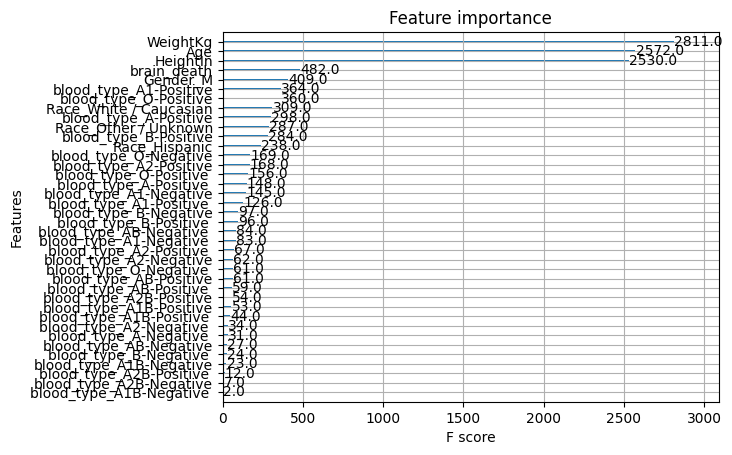

In [28]:
# Plot feature importance
xgb.plot_importance(xg_reg)
plt.show()

## experiment tracking

In [29]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow/mlflow.db")

In [30]:
#mlflow.set_experiment("linear-regresion")
mlflow.set_experiment("random-forest")
#mlflow.set_experiment("xgboost")

<Experiment: artifact_location='/workspaces/health-project-mlops/src/mlruns/1', creation_time=1721504883054, experiment_id='1', last_update_time=1721504883054, lifecycle_stage='active', name='random-forest', tags={}>

In [32]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope


def run_optimization_rf(
    num_trials: int,
    X_train: pd.DataFrame, 
    y_train: pd.DataFrame, 
    X_val: pd.DataFrame, 
    y_val: pd.DataFrame):


    def objective(params):
        with mlflow.start_run():
            mlflow.log_params(params)
            rf = RandomForestRegressor(**params)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_val)
            rmse = mean_squared_error(y_val, y_pred, squared=False)
            mlflow.log_metric("rmse", rmse)

        return {'loss': rmse, 'status': STATUS_OK}

    search_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 10, 50, 1)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, 1)),
        'random_state': 42
    }

    rstate = np.random.default_rng(42)  # for reproducible results
    fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=num_trials,
        trials=Trials(),
        rstate=rstate
    )

In [34]:
run_optimization_rf(10, X_train, y_train, X_test, y_test)

 10%|█         | 1/10 [00:00<00:06,  1.31trial/s, best loss: 2.23844110741227]

/workspaces/health-project-mlops/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 20%|██        | 2/10 [00:00<00:03,  2.30trial/s, best loss: 2.1651243514690277]

/workspaces/health-project-mlops/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 30%|███       | 3/10 [00:01<00:02,  2.99trial/s, best loss: 2.1651243514690277]

/workspaces/health-project-mlops/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 40%|████      | 4/10 [00:01<00:02,  2.41trial/s, best loss: 2.1651243514690277]

/workspaces/health-project-mlops/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 50%|█████     | 5/10 [00:02<00:02,  2.38trial/s, best loss: 2.1651243514690277]

/workspaces/health-project-mlops/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 60%|██████    | 6/10 [00:02<00:02,  1.82trial/s, best loss: 2.1651243514690277]

/workspaces/health-project-mlops/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 70%|███████   | 7/10 [00:03<00:01,  1.57trial/s, best loss: 2.1651243514690277]

/workspaces/health-project-mlops/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 80%|████████  | 8/10 [00:04<00:01,  1.96trial/s, best loss: 2.1651243514690277]

/workspaces/health-project-mlops/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 90%|█████████ | 9/10 [00:04<00:00,  1.75trial/s, best loss: 2.1651243514690277]

/workspaces/health-project-mlops/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



100%|██████████| 10/10 [00:05<00:00,  1.92trial/s, best loss: 2.1651243514690277]


/workspaces/health-project-mlops/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [35]:
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

client = MlflowClient()

experiment = client.get_experiment_by_name('random-forest')
best_run = client.search_runs(
    experiment_ids=experiment.experiment_id,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.test_rmse ASC"]
)[0]

In [36]:
run_id = best_run.info.run_id

In [37]:
best_run.data.metrics

{'rmse': 2.2582785568129164}

In [38]:
model_uri = f"runs:/{run_id}/model"
best_run_test_rmse = best_run.data.metrics["rmse"]
print("Best Run Test RMSE:", best_run_test_rmse)

Best Run Test RMSE: 2.2582785568129164


In [39]:
mlflow.register_model(model_uri=model_uri, name="Random-Forest-Model")

Registered model 'Random-Forest-Model' already exists. Creating a new version of this model...
Created version '2' of model 'Random-Forest-Model'.


<ModelVersion: aliases=[], creation_timestamp=1721524781266, current_stage='None', description=None, last_updated_timestamp=1721524781266, name='Random-Forest-Model', run_id='5ef9833ecfe04013a32c063fb0c57136', run_link=None, source='/workspaces/health-project-mlops/src/mlruns/1/5ef9833ecfe04013a32c063fb0c57136/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [42]:
model_name = "Random-Forest-Model"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: Staging
version: 2, stage: None


/tmp/ipykernel_53732/1539887329.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(name=model_name)


In [41]:
model_name = "Random-Forest-Model"
model_version = 1
new_stage = "Staging" # None, Staging, Production, Archived.
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

/tmp/ipykernel_53732/4140726204.py:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1721506619608, current_stage='Staging', description=None, last_updated_timestamp=1721524803069, name='Random-Forest-Model', run_id='aa7cc2481e6e478390745699e0d0284f', run_link=None, source='/workspaces/health-project-mlops/src/mlruns/1/aa7cc2481e6e478390745699e0d0284f/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>